In [1]:
!pip install torch numpy matplotlib tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm import tqdm

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class ExpertPolicy:
    def __init__(self):
        self.slope = 2
        self.intercept = 1

    def predict(self, X):
        return self.slope * X + self.intercept + np.random.normal(0, 0.1, X.shape)

In [5]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
def generate_initial_data(n_samples=1000):
    X = np.linspace(-10, 10, n_samples)
    expert = ExpertPolicy()
    y = expert.predict(X)
    return X.reshape(-1, 1), y.reshape(-1, 1)

def collect_new_data(model, expert, n_samples=100):
    X_new = np.random.uniform(-10, 10, n_samples).reshape(-1, 1)

    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_new)
        model_predictions = model(X_tensor).numpy()

    expert_labels = expert.predict(X_new)
    return X_new, expert_labels

In [7]:
def train_dagger(initial_dataset, n_iterations=5, n_epochs=20):
    expert = ExpertPolicy()
    model = SimpleNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    current_dataset = initial_dataset
    train_loader = DataLoader(current_dataset, batch_size=32, shuffle=True)

    all_losses = []
    iteration_losses = []

    for iteration in range(n_iterations):
        print(f"\nDAgger Iteration {iteration + 1}/{n_iterations}")

        # Training loop
        model.train()
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)
            all_losses.append(avg_epoch_loss)

            if epoch % 5 == 0:
                print(f"Epoch [{epoch}/{n_epochs}], Loss: {avg_epoch_loss:.4f}")

        iteration_losses.append(np.mean(all_losses[-n_epochs:]))

        # Collect new data
        if iteration < n_iterations - 1:
            X_new, y_new = collect_new_data(model, expert)
            new_dataset = CustomDataset(X_new, y_new)
            current_dataset = ConcatDataset([current_dataset, new_dataset])
            train_loader = DataLoader(current_dataset, batch_size=32, shuffle=True)

    return model, all_losses, iteration_losses

In [8]:
# Generate initial data
X_initial, y_initial = generate_initial_data()
initial_dataset = CustomDataset(X_initial, y_initial)

# Train using DAgger
model, all_losses, iteration_losses = train_dagger(initial_dataset)


DAgger Iteration 1/5
Epoch [0/20], Loss: 108.2840
Epoch [5/20], Loss: 0.1076
Epoch [10/20], Loss: 0.0691
Epoch [15/20], Loss: 0.0461

DAgger Iteration 2/5
Epoch [0/20], Loss: 0.0305
Epoch [5/20], Loss: 0.0194
Epoch [10/20], Loss: 0.0144
Epoch [15/20], Loss: 0.0113

DAgger Iteration 3/5
Epoch [0/20], Loss: 0.0107
Epoch [5/20], Loss: 0.0104
Epoch [10/20], Loss: 0.0105
Epoch [15/20], Loss: 0.0101

DAgger Iteration 4/5
Epoch [0/20], Loss: 0.0101
Epoch [5/20], Loss: 0.0101
Epoch [10/20], Loss: 0.0101
Epoch [15/20], Loss: 0.0103

DAgger Iteration 5/5
Epoch [0/20], Loss: 0.0104
Epoch [5/20], Loss: 0.0105
Epoch [10/20], Loss: 0.0104
Epoch [15/20], Loss: 0.0103


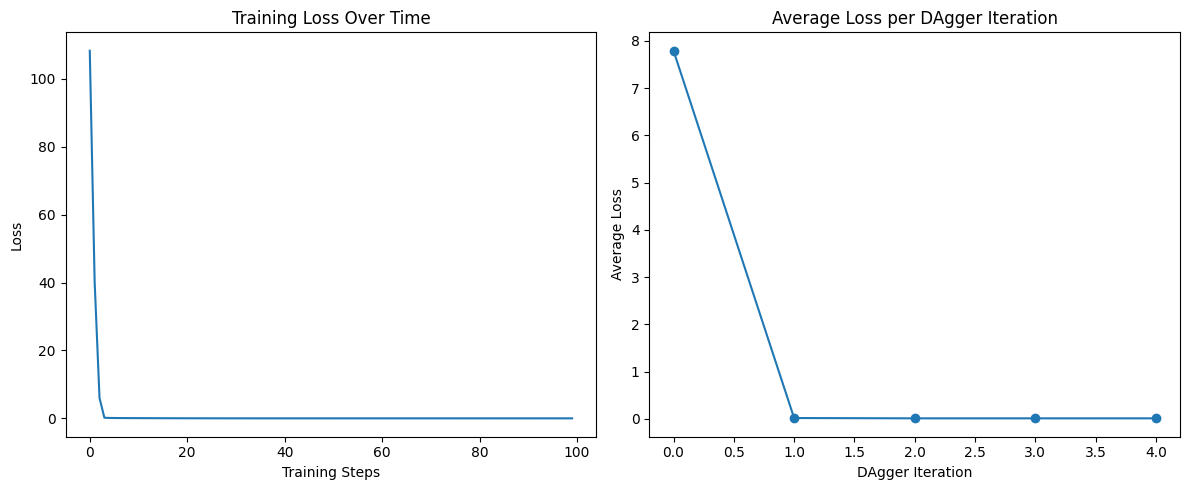

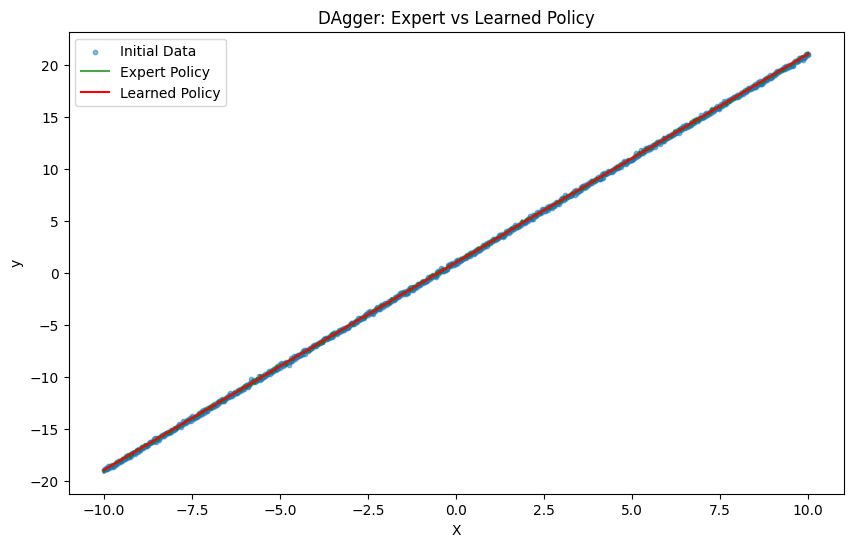

In [9]:
# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(all_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(iteration_losses, marker='o')
plt.title('Average Loss per DAgger Iteration')
plt.xlabel('DAgger Iteration')
plt.ylabel('Average Loss')
plt.tight_layout()
plt.show()

# Plot predictions
X_test = np.linspace(-10, 10, 1000).reshape(-1, 1)
expert = ExpertPolicy()
y_expert = expert.predict(X_test)

model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_test)
    predictions = model(X_tensor).numpy()

plt.figure(figsize=(10, 6))
plt.scatter(X_initial, y_initial, alpha=0.5, label='Initial Data', s=10)
plt.plot(X_test, y_expert, color='green', label='Expert Policy', alpha=0.7)
plt.plot(X_test, predictions, color='red', label='Learned Policy')
plt.title('DAgger: Expert vs Learned Policy')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()